In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.feature_selection import chi2
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import label_binarize


In [3]:
matches = pd.read_csv('matches_final.csv')

In [5]:
players = pd.read_csv('players_final.csv')

In [7]:
matches.head()

,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,rain_sum,snowfall_sum,Team,Squad_size,Avg Age,Foreigners,Avg Market Value,Total Market Value,Avg Market Value in millions,Total Market Value in millions
0,2014,8/23/2014,Almeria,Espanol,1,1,D,0,0,D,...,0.6,0.0,Almeria,31,25.5,11,€1.24m,€38.30m,1.24,38.30
1,2014,8/23/2014,Granada,La Coruna,2,1,H,0,1,A,...,0.0,0.0,Granada,39,25.8,22,€1.73m,€67.55m,1.73,67.55
2,2014,8/23/2014,Malaga,Ath Bilbao,1,0,H,1,0,H,...,0.0,0.0,Malaga,30,27.1,18,€2.76m,€82.80m,2.76,82.80
3,2014,8/23/2014,Sevilla,Valencia,1,1,D,1,0,H,...,0.0,0.0,Sevilla,34,25.5,14,€4.90m,€166.75m,4.90,166.75
4,2014,8/24/2014,Barcelona,Elche,3,0,H,1,0,H,...,1.5,0.0,Barcelona,31,25.9,17,€19.48m,€603.80m,19.48,603.80


In [9]:
players.head()

,Season,Player,Nation,Pos,Squad,Age,Born,MP,Starts,Min,...,Per_90_Gls,Per_90_Ast,Per_90_G+A,Per_90_G-PK,Per_90_G+A-PK,Per_90_xG,Per_90_XAG,Per_90_XG+AG,Per_90_npxG,Per_90_npxG+AG
0,2014,Issam El Adoua,ma MAR,DF,Levante,27,1986,4,3,290,...,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN
1,2014,Adriano,br BRA,"DF,MF",Barcelona,29,1984,16,10,962,...,0.00,0.09,0.09,0.00,0.09,NaN,NaN,NaN,NaN,NaN
2,2014,Aritz Aduriz,es ESP,FW,Ath Bilbao,33,1981,31,30,2579,...,0.63,0.10,0.73,0.45,0.56,NaN,NaN,NaN,NaN,NaN
3,2014,Imanol Agirretxe,es ESP,FW,Sociedad,27,1987,31,21,1946,...,0.32,0.05,0.37,0.32,0.37,NaN,NaN,NaN,NaN,NaN
4,2014,Ager Aketxe,es ESP,MF,Ath Bilbao,20,1993,8,3,299,...,0.30,0.30,0.60,0.30,0.60,NaN,NaN,NaN,NaN,NaN


## Merging the two datasets

### Merging home team

In [13]:
home_merge = pd.merge(matches, players, left_on=['Season', 'HomeTeam'], right_on=['Season', 'Squad'], how='outer',
    suffixes=('_match', '_player'))

### Merging away team

In [16]:
# Merge for away teams
away_merge = pd.merge( matches, players, left_on=['Season', 'AwayTeam'], right_on=['Season', 'Squad'], how='outer',
    suffixes=('_match', '_player'))


In [18]:
# Combine home and away merges
final_df = pd.concat([home_merge, away_merge], ignore_index=True)

In [20]:
duplicates = final_df.duplicated().sum()
print(duplicates)

0


In [21]:
columns_with_nulls = final_df.columns[final_df.isnull().any()].tolist()
print(columns_with_nulls)

['Exp_xG', 'Exp_npxG', 'Exp_xAG', 'Exp_npxG+xAG', 'Prog_PrgC', 'Prog_PrgP', 'Prog_PrgR', 'Per_90_xG', 'Per_90_XAG', 'Per_90_XG+AG', 'Per_90_npxG', 'Per_90_npxG+AG']


In [22]:
imputer = SimpleImputer(strategy='constant', fill_value=0)
final_df[columns_with_nulls] = imputer.fit_transform(final_df[columns_with_nulls])

In [23]:
# Sort data by player and match date to track changes over time
final_df['Date'] = pd.to_datetime(final_df['Date'])
final_df.sort_values(by=['Player', 'Date'])

player_positions = final_df.groupby('Player')['Pos'].apply(list).reset_index()

print(player_positions)

                 Player                                                Pos
0       Aarón Escandell  [GK, GK, GK, GK, GK, GK, GK, GK, GK, GK, GK, G...
1          Aarón Martín  [DF,MF, DF,MF, DF,MF, DF,MF, DF,MF, DF,MF, DF,...
2          Aarón Ñíguez  [FW,MF, FW,MF, FW,MF, FW,MF, FW,MF, FW,MF, FW,...
3     Abdallahi Mahmoud  [MF, MF, MF, MF, MF, MF, MF, MF, MF, MF, MF, M...
4       Abde Ezzalzouli  [FW, FW, FW, FW, FW, FW, FW, FW, FW, FW, FW, F...
...                 ...                                                ...
2152    Óscar de Marcos  [DF,FW, DF,FW, DF,FW, DF,FW, DF,FW, DF,FW, DF,...
2153       Ørjan Nyland  [GK, GK, GK, GK, GK, GK, GK, GK, GK, GK, GK, G...
2154     İlkay Gündoğan  [MF, MF, MF, MF, MF, MF, MF, MF, MF, MF, MF, M...
2155     İsmail Köybaşı  [DF,FW, DF,FW, DF,FW, DF,FW, DF,FW, DF,FW, DF,...
2156      Šime Vrsaljko  [DF,MF, DF,MF, DF,MF, DF,MF, DF,MF, DF,MF, DF,...

[2157 rows x 2 columns]


In [25]:
final_df['Pos'].unique()

array(['MF', 'FW,MF', 'GK', 'FW', 'DF', 'DF,FW', 'DF,MF', 'MF,FW',
       'MF,DF', 'FW,DF'], dtype=object)

In [27]:

# mapping the orginal positions to more meaningful
pos_map = {'MF': 'Midfielder', 'FW': 'Forward','GK': 'Goalkeeper', 'DF': 'Defender', 'FW,MF': 'Forward/Midfielder', 'DF,FW': 'Defender/Forward',
    'DF,MF': 'Defender/Midfielder', 'MF,FW': 'Midfielder/Forward', 'MF,DF': 'Midfielder/Defender', 'FW,MF':'Midfielder/Forward',
          'FW,DF':'Defender/Forwar'}

final_df['Pos'] = final_df['Pos'].map(pos_map)

In [29]:
final_df['Avg Market Value in millions'] = final_df['Avg Market Value in millions'] * 1e6
final_df['Total Market Value in millions'] = final_df['Total Market Value in millions'] * 1e6

In [30]:
final_df.dtypes

Season                     int64
Date              datetime64[ns]
HomeTeam                  object
AwayTeam                  object
FTHG                       int64
                       ...      
Per_90_xG                float64
Per_90_XAG               float64
Per_90_XG+AG             float64
Per_90_npxG              float64
Per_90_npxG+AG           float64
Length: 80, dtype: object

In [31]:
# Changing Season column to category
final_df['Season'] = final_df['Season'].astype(object)

In [38]:
# Extract useful features
final_df['Year'] = final_df['Date'].dt.year
final_df['Month'] = final_df['Date'].dt.month
final_df['Day'] = final_df['Date'].dt.day
final_df['Weekday'] = final_df['Date'].dt.weekday  # 0 = Monday, 6 = Sunday

# Drop the original 'Date' column
final_df = final_df.drop('Date', axis=1)

In [40]:
final_df['Year'] = final_df['Year'].astype(object)
final_df['Month'] = final_df['Month'].astype(object)
final_df['Day'] = final_df['Day'].astype(object)
final_df['Weekday'] = final_df['Weekday'].astype(object)

In [42]:
# droping columns --> 'Avg Market Value', 'Total Market Value', 'Nation', 'City', 'Place', 'Born', 'Place', 'Team_unicode'
cols = ['Avg Market Value', 'Total Market Value', 'Nation', 'City', 'Place', 'Born', 'Place', 'Team_unicode','Team']
final_df.drop(columns = cols, axis = 1, inplace = True)
final_df.columns

Index(['Season', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG',
       'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY',
       'HR', 'AR', 'Stadium', 'Latitude', 'Longitude', 'max_temp', 'min_temp',
       'apparent_temperature_max', 'apparent_temperature_min', 'wind_speed',
       'weather_code', 'precipitation_sum', 'rain_sum', 'snowfall_sum',
       'Squad_size', 'Avg Age', 'Foreigners', 'Avg Market Value in millions',
       'Total Market Value in millions', 'Player', 'Pos', 'Squad', 'Age', 'MP',
       'Starts', 'Min', '90s', 'Perf_Gls', 'Perf_Ast', 'Perf_G+A', 'Perf_G-PK',
       'Perf_PK', 'Perf_PKatt', 'Perf_CrdY', 'Perf_CrdR', 'Exp_xG', 'Exp_npxG',
       'Exp_xAG', 'Exp_npxG+xAG', 'Prog_PrgC', 'Prog_PrgP', 'Prog_PrgR',
       'Per_90_Gls', 'Per_90_Ast', 'Per_90_G+A', 'Per_90_G-PK',
       'Per_90_G+A-PK', 'Per_90_xG', 'Per_90_XAG', 'Per_90_XG+AG',
       'Per_90_npxG', 'Per_90_npxG+AG', 'Year', 'Month', 'Day', 'Weekday'],
      dtype='objec

## Feature Engineering

In [45]:
df = final_df.copy()

In [47]:
# Creating new features based on shots
df['ST_Diff'] = df['HST'] - df['AST'] # The more number of shots a team takes there is more possibility of getting a goal
df['Home_Shot_Acc'] = df['HST']/(df['HS'] + 1e-6) # The more shots on target more possibility to win
df['Away_Shot_Acc'] = df['AST']/(df['AS'] + 1e-6)

### Trying to find the weather weights

In [50]:
df["HomeWin"] = (df["FTR"] == "H").astype(int)

# Select relevant features
X = df[["wind_speed", "rain_sum", "snowfall_sum"]]
y = df["HomeWin"]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Fit a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Getting the weights of the model
coefficients = model.coef_[0]
abs(coefficients)/sum(abs(coefficients))

array([0.48407055, 0.43145509, 0.08447436])

In [51]:
df["Weather_Impact"] = 0.484 * df["wind_speed"] + 0.431 * df["rain_sum"] + 0.084 * df["snowfall_sum"]

### Market Value Ratio

In [55]:
# Compares the market values for the home and away team for that season
market_values = df.groupby(["Season", "AwayTeam"])["Total Market Value in millions"].mean()
df["Market_Val_Ratio"] = df.apply(lambda row: row["Total Market Value in millions"] / market_values.get((row["Season"], row["AwayTeam"]), 1e-6), axis=1)

### Home Advantage Score  

In [57]:
# Home points
df['HomePoints'] = 0
df.loc[df['FTHG'] > df['FTAG'], 'HomePoints'] = 3  # Home win
df.loc[df['FTHG'] == df['FTAG'], 'HomePoints'] = 1  # Draw

# Away points
df['AwayPoints'] = 0 
df.loc[df['FTAG'] > df['FTHG'], 'AwayPoints'] = 3  # Away win
df.loc[df['FTAG'] == df['FTHG'], 'AwayPoints'] = 1  # Draw

# Total home points per season and team
home_points = df.groupby(['Season', 'HomeTeam'])['HomePoints'].sum().reset_index()
home_points.columns = ['Season', 'HomeTeam', 'TotalHomePoints']

# Total away points per season and team
away_points = df.groupby(['Season', 'AwayTeam'])['AwayPoints'].sum().reset_index()
away_points.columns = ['Season', 'AwayTeam', 'TotalAwayPoints']

df = df.merge(home_points, on=['Season', 'HomeTeam'], how='left')

away_points = away_points.rename(columns={'AwayTeam': 'HomeTeam'})
df = df.merge(away_points, on=['Season', 'HomeTeam'], how='left')

# Calculate total points and home advantage score
df['TotalPoints'] = df['TotalHomePoints'].fillna(0) + df['TotalAwayPoints'].fillna(0)
df['Home_Adv_Score'] = df['TotalHomePoints'] / df['TotalPoints']
df['Home_Adv_Score'] = df['Home_Adv_Score'].fillna(0)

### Foreigners influence

In [59]:
df["Foreign_Influence"] = df.apply(lambda row: row["Foreigners"] / (row["Squad_size"] + 1e-6), axis=1)

### Recent form rolling win% over last 5 games

In [61]:
df['HomeForm'] = (df.groupby('HomeTeam')['HomeWin'].rolling(window=5, min_periods=1).mean().reset_index(level=0, drop=True))

# For away teams
df['AwayWin'] = (df['FTR'] == 'A').astype(int)
df['AwayForm'] = (df.groupby('AwayTeam')['AwayWin'].rolling(window=5, min_periods=1).mean().reset_index(level=0, drop=True))

df['HomeForm'] = df['HomeForm'].fillna(0)
df['AwayForm'] = df['AwayForm'].fillna(0)

In [62]:
df.drop(columns = ['HomePoints', 'AwayPoints', 'TotalHomePoints', 'TotalAwayPoints', 'TotalPoints', 'AwayWin', 'HomeWin'], inplace =True)

# Taking the necessary columns for finding necessary correlation
necessary cols = ['Season', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG',
       'HTAG', 'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY',
       'AY', 'HR', 'AR', 'Stadium', 'City', 'Latitude', 'Longitude', 'Place',
       'Team_unicode', 'max_temp', 'min_temp', 'apparent_temperature_max',
       'apparent_temperature_min', 'wind_speed', 'weather_code',
       'precipitation_sum', 'rain_sum', 'snowfall_sum', 'Team', 'Squad_size',
       'Avg Age', 'Foreigners', 'Avg Market Value', 'Total Market Value',
       'Avg Market Value in millions', 'Total Market Value in millions',
       'Player', 'Nation', 'Pos', 'Squad', 'Age', 'Born', 'MP', 'Starts',
       'Min', '90s', 'Perf_Gls', 'Perf_Ast', 'Perf_G+A', 'Perf_G-PK',
       'Perf_PK', 'Perf_PKatt', 'Perf_CrdY', 'Perf_CrdR', 'Exp_xG', 'Exp_npxG',
       'Exp_xAG', 'Exp_npxG+xAG', 'Prog_PrgC', 'Prog_PrgP', 'Prog_PrgR',
       'Per_90_Gls', 'Per_90_Ast', 'Per_90_G+A', 'Per_90_G-PK',
       'Per_90_G+A-PK', 'Per_90_xG', 'Per_90_XAG', 'Per_90_XG+AG',
       'Per_90_npxG', 'Per_90_npxG+AG', 'foreigner', 'Home_Adv_Score',
       'HomeWin', 'Market_Val_Ratio', 'Foreign_Influence']

# Columns to be removed --> 'Date','Team_unicode','Avg Market Value','Total Market Value',''   


### Encoding categorical values

In [65]:
cols = ['Season', 'Date', 'HomeTeam', 'AwayTeam', 'Place']

In [66]:
# For encoding used one hot encoding as i was encoding for the full time result and i did not want to have any bias towards a partiucalr result.

In [67]:
encoder = OneHotEncoder(sparse_output=False, drop=None)

ftr_encoded = encoder.fit_transform(df[['FTR']])
feature_names = encoder.get_feature_names_out(['FTR'])
ftr_encoded_df = pd.DataFrame(ftr_encoded, columns=feature_names)
df_encoded = pd.concat([df.drop('FTR', axis=1), ftr_encoded_df], axis=1)

In [68]:
df_encoded.head()

,Season,HomeTeam,AwayTeam,FTHG,FTAG,HTHG,HTAG,HTR,HS,AS,...,Away_Shot_Acc,Weather_Impact,Market_Val_Ratio,Home_Adv_Score,Foreign_Influence,HomeForm,AwayForm,FTR_A,FTR_D,FTR_H
0,2014,Almeria,Espanol,1,1,0,0,D,19,12,...,0.166667,6.9378,0.243955,0.503468,0.354839,0.0,0.0,0.0,1.0,0.0
1,2014,Almeria,Espanol,1,1,0,0,D,19,12,...,0.166667,6.9378,0.243955,0.503468,0.354839,0.0,0.0,0.0,1.0,0.0
2,2014,Almeria,Espanol,1,1,0,0,D,19,12,...,0.166667,6.9378,0.243955,0.503468,0.354839,0.0,0.0,0.0,1.0,0.0
3,2014,Almeria,Espanol,1,1,0,0,D,19,12,...,0.166667,6.9378,0.243955,0.503468,0.354839,0.0,0.0,0.0,1.0,0.0
4,2014,Almeria,Espanol,1,1,0,0,D,19,12,...,0.166667,6.9378,0.243955,0.503468,0.354839,0.0,0.0,0.0,1.0,0.0


In [69]:
categorical_cols = df_encoded.select_dtypes(include=['object']).columns
print("Categorical columns:", categorical_cols)
df_encode_new = df_encoded.copy()
# Label encode each categorical column
for col in categorical_cols:
    le = LabelEncoder()
    df_encode_new[col] = le.fit_transform(df_encode_new[col].astype(str))

Categorical columns: Index(['Season', 'HomeTeam', 'AwayTeam', 'HTR', 'Stadium', 'Player', 'Pos',
       'Squad', 'Year', 'Month', 'Day', 'Weekday'],
      dtype='object')


In [70]:
correlation_matrix = df_encode_new.corr()

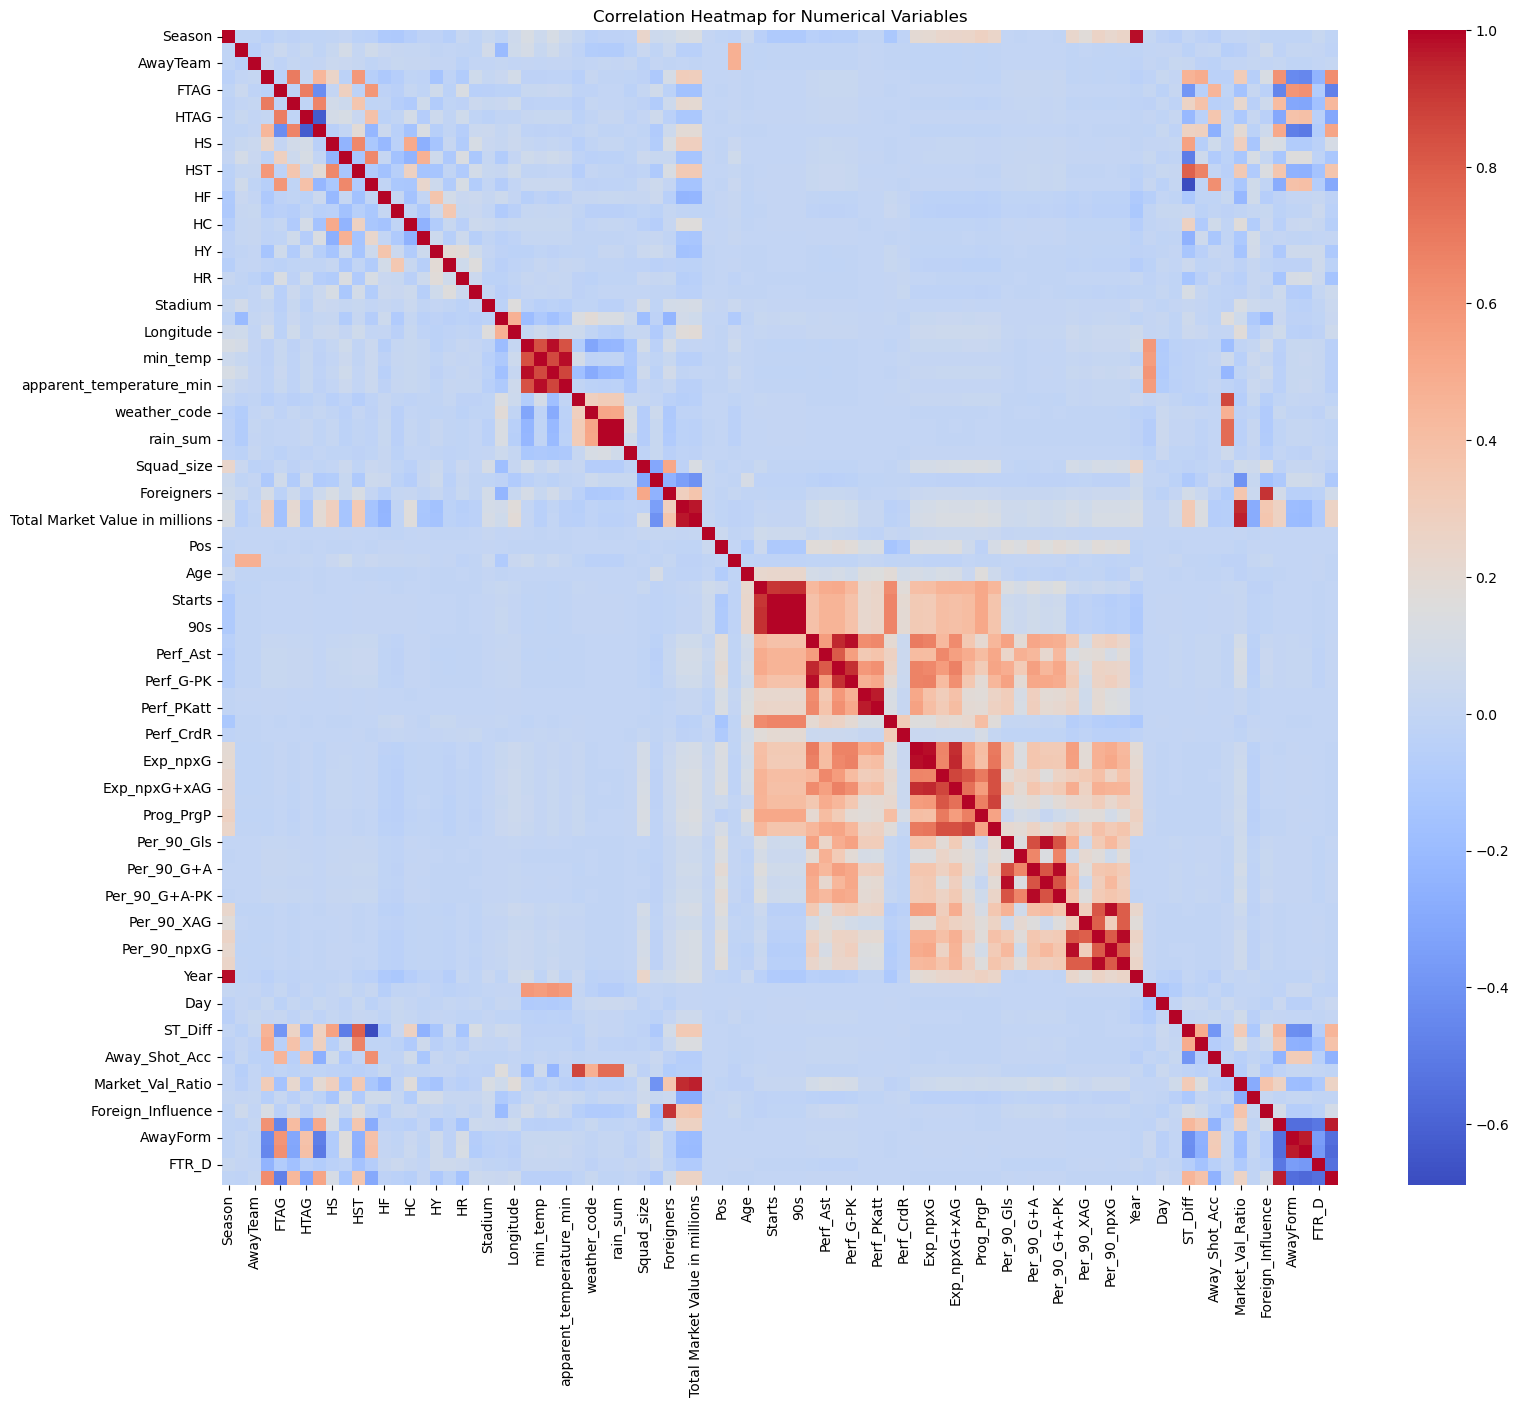

In [71]:
# Plot the heatmap
plt.figure(figsize=(18, 15))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap for Numerical Variables")
plt.savefig('correlation_matrix.png')
plt.show()

In [72]:
ftr_h_corr = correlation_matrix['FTR_H'].sort_values(ascending=False)
print(ftr_h_corr[:10])

FTR_H                             1.000000
HomeForm                          0.960953
FTHG                              0.627744
HTR                               0.527544
ST_Diff                           0.449005
HTHG                              0.432871
Home_Shot_Acc                     0.373847
HST                               0.364714
Total Market Value in millions    0.264277
Market_Val_Ratio                  0.263663
Name: FTR_H, dtype: float64


In [73]:
ftr_a_corr = correlation_matrix['FTR_A'].sort_values(ascending=False)
print(ftr_a_corr[:10])

FTR_A            1.000000
AwayForm         0.961698
FTAG             0.616426
AST              0.394173
HTAG             0.390133
Away_Shot_Acc    0.326981
AS               0.160030
HR               0.112423
Avg Age          0.071928
HY               0.060204
Name: FTR_A, dtype: float64


In [74]:
ftr_d_corr = correlation_matrix['FTR_D'].sort_values(ascending=False)
print(ftr_d_corr[:10])

FTR_D           1.000000
HY              0.060956
AY              0.058178
AF              0.049229
HR              0.048633
Avg Age         0.044478
Season          0.029919
Year            0.023108
HC              0.023069
snowfall_sum    0.022949
Name: FTR_D, dtype: float64


In [75]:
# Correlation matrix
corr_matrix = df_encode_new.corr()

# Mask upper triangle (exclude diagonal)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
corr_matrix_lower = corr_matrix.where(~mask)

# Find pairs >= 0.95, exclude NaNs and self-pairs
threshold = 0.95
high_corr_pairs = np.where(np.abs(corr_matrix_lower) >= threshold)
correlated_pairs = [(corr_matrix_lower.index[i], corr_matrix_lower.columns[j], corr_matrix_lower.iloc[i, j])
                    for i, j in zip(*high_corr_pairs)
                    if i != j and not pd.isna(corr_matrix_lower.iloc[i, j])]

# Create dataframe and sort by absolute correlation
correlated_df = pd.DataFrame(correlated_pairs, columns=['Feature1', 'Feature2', 'Correlation'])
correlated_df = correlated_df[correlated_df['Feature1'] != correlated_df['Feature2']]  # Double-check distinct
correlated_df = correlated_df.sort_values(by='Correlation', key=abs, ascending=False)

print("Highly correlated pairs (threshold = 0.95, sorted):")
correlated_df

Highly correlated pairs (threshold = 0.95, sorted):


,Feature1,Feature2,Correlation
6,90s,Min,0.999997
2,rain_sum,precipitation_sum,0.998822
4,Min,Starts,0.994430
5,90s,Starts,0.994419
13,Per_90_npxG+AG,Per_90_XG+AG,0.991922
11,Per_90_G+A-PK,Per_90_G+A,0.989735
14,Year,Season,0.986733
1,apparent_temperature_min,min_temp,0.985210
7,Perf_G-PK,Perf_Gls,0.982904
10,Per_90_G-PK,Per_90_Gls,0.982391


In [76]:
categorical_cols = ['Season','HomeTeam','AwayTeam','HTR','Player','Pos','Stadium', 'weather_code']
X_cat = df_encoded[categorical_cols]
y = df_encoded['FTR_H']

X_cat_encoded = X_cat.apply(LabelEncoder().fit_transform)

# Compute chi-square stats
chi_scores, p_values = chi2(X_cat_encoded, y)
chi_results = pd.DataFrame({'Feature': categorical_cols, 'Chi2 Score': chi_scores, 'P-value': p_values})
print(chi_results.sort_values('Chi2 Score', ascending=False))

        Feature    Chi2 Score        P-value
3           HTR  32164.406883   0.000000e+00
6       Stadium   4477.850043   0.000000e+00
1      HomeTeam    539.242792  2.755254e-119
2      AwayTeam    215.167295   1.024642e-48
0        Season     99.673540   1.797061e-23
7  weather_code     85.836886   1.954070e-20
4        Player      0.159912   6.892380e-01
5           Pos      0.012872   9.096685e-01


In [77]:
categorical_cols = ['Season','HomeTeam','AwayTeam','HTR','Player','Pos','Stadium', 'weather_code']
X_cat = df_encoded[categorical_cols]
y = df_encoded['FTR_A']

X_cat_encoded = X_cat.apply(LabelEncoder().fit_transform)

# Compute chi-square stats
chi_scores, p_values = chi2(X_cat_encoded, y)
chi_results = pd.DataFrame({'Feature': categorical_cols, 'Chi2 Score': chi_scores, 'P-value': p_values})
print(chi_results.sort_values('Chi2 Score', ascending=False))

        Feature    Chi2 Score       P-value
3           HTR  29555.213235  0.000000e+00
6       Stadium   4416.217439  0.000000e+00
2      AwayTeam    286.934963  2.314260e-64
1      HomeTeam    279.455321  9.869416e-63
0        Season     68.358013  1.363500e-16
5           Pos      1.904289  1.675990e-01
4        Player      1.260630  2.615319e-01
7  weather_code      0.003132  9.553693e-01


In [78]:
categorical_cols = ['Season','HomeTeam','AwayTeam','HTR','Player','Pos','Stadium', 'weather_code']
X_cat = df_encoded[categorical_cols]
y = df_encoded['FTR_D']
X_cat_encoded = X_cat.apply(LabelEncoder().fit_transform)

# Compute chi-square stats
chi_scores, p_values = chi2(X_cat_encoded, y)
chi_results = pd.DataFrame({'Feature': categorical_cols, 'Chi2 Score': chi_scores, 'P-value': p_values})
print(chi_results.sort_values('Chi2 Score', ascending=False))

        Feature  Chi2 Score        P-value
3           HTR  722.609361  3.624602e-159
0        Season  390.660207   5.944971e-87
7  weather_code  111.123084   5.560873e-26
1      HomeTeam   83.856656   5.319818e-20
6       Stadium   58.748407   1.791786e-14
4        Player    2.567698   1.090664e-01
5           Pos    1.650934   1.988319e-01
2      AwayTeam    0.560957   4.538749e-01


In [79]:
X = df_encoded.drop(['FTR_H', 'FTR_A', 'FTR_D'], axis=1)
y = df_encoded['FTR_H']

for col in X.select_dtypes(include='object').columns:
    X[col] = LabelEncoder().fit_transform(X[col])

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
importances.sort_values('Importance', ascending=False)[:20]

,Feature,Importance
81,HomeForm,0.377467
3,FTHG,0.181472
4,FTAG,0.090468
82,AwayForm,0.068595
7,HTR,0.044150
74,ST_Diff,0.031457
5,HTHG,0.023688
75,Home_Shot_Acc,0.018996
10,HST,0.016283
6,HTAG,0.015801


In [80]:
# trying to convert all the categorical columns to columns using one hot encoding and looking at the feature set.

In [81]:
categorical_cols = df_encoded.select_dtypes(include=['object']).columns
print(categorical_cols)

Index(['Season', 'HomeTeam', 'AwayTeam', 'HTR', 'Stadium', 'Player', 'Pos',
       'Squad', 'Year', 'Month', 'Day', 'Weekday'],
      dtype='object')


Using RFE on both the datasets to understand which features are better

In [83]:
df_encoded['FTR_label'] = np.select(
    [df_encoded['FTR_H'] == 1, df_encoded['FTR_A'] == 1, df_encoded['FTR_D'] == 1],
    [0, 1, 2])

In [84]:
df_encoded = shuffle(df_encoded, random_state=42)
df_encoded['weather_severity'] = df_encoded['wind_speed'] * df_encoded['precipitation_sum']
df_encoded['high_wind'] = (df_encoded['wind_speed'] > 15).astype(int)
df_encoded['rainy'] = (df_encoded['precipitation_sum'] > 5).astype(int)
df_encoded['temp_wind'] = df_encoded['max_temp'] * df_encoded['wind_speed']
if 'max_temp' in df_encoded.columns and 'min_temp' in df_encoded.columns:
    df_encoded['temp_range'] = df_encoded['max_temp'] - df_encoded['min_temp']

leakage_columns = ['FTHG', 'FTAG', 'FTR_H', 'FTR_A', 'FTR_D','FTR_label', 'HTR', 'HTAG',
                   'HTHG','90s', 'rain_sum','Starts', 'Per_90_npxG+AG', 'Per_90_G+A-PK',
                  'apparent_temperature_min', 'Perf_G-PK','Per_90_G-PK','Exp_npxG','apparent_temperature_max',
                  'Per_90_npxG', 'Perf_PKatt']
X = df_encoded.drop(columns=leakage_columns, errors='ignore')
y = df_encoded['FTR_label']
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64','float64','int32','float32']).columns.tolist()

Xy = pd.concat([X, y], axis=1)
Xy_dedup = Xy.drop_duplicates()

print("Original rows:", Xy.shape[0])
print("Deduplicated rows:", X.shape[0])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('scaler', StandardScaler())]), numerical_cols),
        ('cat', Pipeline(steps=[('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))]), categorical_cols)])

X_transformed = preprocessor.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split( X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

rf_model = RandomForestClassifier(n_estimators=70, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)

y_train_pred = rf_model.predict(X_train)
y_val_pred = rf_model.predict(X_val)
y_test_pred = rf_model.predict(X_test)

print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation Report:\n", classification_report(y_val, y_val_pred, target_names=['Home', 'Away', 'Draw']))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test Report:\n", classification_report(y_test, y_test_pred, target_names=['Home', 'Away', 'Draw']))

print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Train Report:\n", classification_report(y_train, y_train_pred, target_names=['Home', 'Away', 'Draw']))

feature_importances = rf_model.feature_importances_
feature_names = numerical_cols + categorical_cols  # Order matches ColumnTransformer output
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
print("\nFeature Importance:")
print(importances_df.sort_values('Importance', ascending=False))

Original rows: 230734
Deduplicated rows: 230734
Validation Accuracy: 0.9687957094100439
Validation Report:
               precision    recall  f1-score   support

        Home       0.95      1.00      0.97      8384
        Away       0.97      0.98      0.98      5230
        Draw       1.00      0.91      0.95      4845

    accuracy                           0.97     18459
   macro avg       0.97      0.96      0.97     18459
weighted avg       0.97      0.97      0.97     18459

Test Accuracy: 0.9692937785771556
Test Report:
               precision    recall  f1-score   support

        Home       0.96      1.00      0.98     20959
        Away       0.97      0.98      0.97     13075
        Draw       1.00      0.91      0.95     12113

    accuracy                           0.97     46147
   macro avg       0.97      0.96      0.97     46147
weighted avg       0.97      0.97      0.97     46147

Train Accuracy: 0.9704264181835693
Train Report:
               precision    recal

In [133]:
df_encoded = shuffle(df_encoded, random_state=42)
df_encoded['weather_severity'] = df_encoded['wind_speed'] * df_encoded['precipitation_sum']
df_encoded['high_wind'] = (df_encoded['wind_speed'] > 15).astype(int)
df_encoded['rainy'] = (df_encoded['precipitation_sum'] > 5).astype(int)
df_encoded['temp_wind'] = df_encoded['max_temp'] * df_encoded['wind_speed']
if 'max_temp' in df_encoded.columns and 'min_temp' in df_encoded.columns:
    df_encoded['temp_range'] = df_encoded['max_temp'] - df_encoded['min_temp']

leakage_columns = ['FTHG', 'FTAG', 'FTR_H', 'FTR_A', 'FTR_D','FTR_label', 'HTR', 'HTAG', 'HTHG','90s', 'rain_sum','Starts', 'Per_90_npxG+AG', 'Per_90_G+A-PK', 
            'apparent_temperature_min','Perf_G-PK','Per_90_G-PK','Exp_npxG','apparent_temperature_max', 'Per_90_npxG', 'Perf_PKatt','Pos', 'Avg Market Value in millions',
            'Market_Val_Ratio', 'HomeForm', 'AwayForm','Latitude', 'Longitude', 'Perf_PK', 'Perf_Gls', 'Per_90_Ast', 'Age', 'Perf_CrdR', 'Prog_PrgP','Prog_PrgR',
            'Squad', 'Exp_xG','Per_90_XG+AG', 'Per_90_XAG', 'Per_90_Gls', 'Per_90_G+A', 'Per_90_xG', 'Prog_PrgC', 'Perf_G+A', 'Perf_Ast', 'Min', 'Perf_CrdY', 'MP',
            'Exp_xAG', 'Exp_npxG+xAG','Day', 'Avg Age', 'Foreigners', 'Squad_size', 'ST_Diff', 'Home_Shot_Acc', 'Away_Shot_Acc','Total Market Value in millions',
            'AwayTeam' , 'AST', 'HS', 'HC', 'AC', 'AF', 'AS', 'HY', 'AY', 'Month', 'HomeTeam', 'HST']

X = df_encoded.drop(columns=leakage_columns, errors='ignore')
y = df_encoded['FTR_label']
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64','float64','int32','float32']).columns.tolist()

Xy = pd.concat([X, y], axis=1)
Xy_dedup = Xy.drop_duplicates()
X = Xy_dedup.drop(columns=['FTR_label'])
y = Xy_dedup['FTR_label']
print("Original rows:", Xy.shape[0])
print("Deduplicated rows:", Xy_dedup.shape[0])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('scaler', StandardScaler())]), numerical_cols),
        ('cat', Pipeline(steps=[('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))]), categorical_cols)])

X = preprocessor.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split( X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

pipeline_lr = LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42)
pipeline_rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
pipeline_dt = DecisionTreeClassifier(max_depth=10,random_state=42)
pipeline_gb =  GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)
pipeline_xgb =  XGBClassifier(n_estimators=100, max_depth=5, random_state=42, use_label_encoder=False, eval_metric='mlogloss')

def evaluate_model(pipeline, X_train, y_train, X_val, y_val, X_test, y_test, name):
    pipeline.fit(X_train, y_train)
    y_train_pred = pipeline.predict(X_train)
    y_val_pred = pipeline.predict(X_val)
    y_test_pred = pipeline.predict(X_test)
    
    y_val_proba = pipeline.predict_proba(X_val)
    y_test_proba = pipeline.predict_proba(X_test)
    y_val_bin = label_binarize(y_val, classes=[0, 1, 2])
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
    
    val_roc = roc_auc_score(y_val_bin, y_val_proba, multi_class='ovr')
    test_roc = roc_auc_score(y_test_bin, y_test_proba, multi_class='ovr')
    
    print(f"\n{name} Results:")
    print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
    print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
    print("Validation Report:\n", classification_report(y_val, y_val_pred, target_names=['Home', 'Away', 'Draw']))
    print("Validation ROC-AUC (OvR):", val_roc)
    print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
    print("Test Report:\n", classification_report(y_test, y_test_pred, target_names=['Home', 'Away', 'Draw']))
    print("Test ROC-AUC (OvR):", test_roc)
    
    if 'Tree' in name or 'Forest' in name:
        importances = pipeline.feature_importances_
        feature_cols = numerical_cols + categorical_cols
        importances_df = pd.DataFrame({'Feature': feature_cols, 'Importance': importances})
        print("\nFeature Importance:")
        print(importances_df.sort_values('Importance', ascending=False))

# Evaluate
evaluate_model(pipeline_lr, X_train, y_train, X_val, y_val, X_test, y_test, "Logistic Regression")
evaluate_model(pipeline_rf, X_train, y_train, X_val, y_val, X_test, y_test, "Random Forest")
evaluate_model(pipeline_dt, X_train, y_train, X_val, y_val, X_test, y_test, "Decision Tree")
evaluate_model(pipeline_gb, X_train, y_train, X_val, y_val, X_test, y_test, "Gradient Boosting")
evaluate_model(pipeline_xgb, X_train, y_train, X_val, y_val, X_test, y_test, "XGBoost")

Original rows: 230734
Deduplicated rows: 230400


C:\Users\shaun\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\shaun\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression Results:
Train Accuracy: 0.4715711805555556
Validation Accuracy: 0.4749348958333333
Validation Report:
               precision    recall  f1-score   support

        Home       0.48      0.91      0.63      8370
        Away       0.42      0.19      0.26      5224
        Draw       0.45      0.03      0.05      4838

    accuracy                           0.47     18432
   macro avg       0.45      0.38      0.31     18432
weighted avg       0.45      0.47      0.37     18432

Validation ROC-AUC (OvR): 0.5887566958928176
Test Accuracy: 0.47237413194444444
Test Report:
               precision    recall  f1-score   support

        Home       0.48      0.91      0.63     20926
        Away       0.41      0.19      0.26     13058
        Draw       0.46      0.03      0.05     12096

    accuracy                           0.47     46080
   macro avg       0.45      0.37      0.31     46080
weighted avg       0.46      0.47      0.37     46080

Test ROC-AUC (OvR):

C:\Users\shaun\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:59:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Results:
Train Accuracy: 0.9491524402006173
Validation Accuracy: 0.9434136284722222
Validation Report:
               precision    recall  f1-score   support

        Home       0.91      0.99      0.95      8370
        Away       0.98      0.92      0.95      5224
        Draw       0.98      0.89      0.93      4838

    accuracy                           0.94     18432
   macro avg       0.96      0.93      0.94     18432
weighted avg       0.95      0.94      0.94     18432

Validation ROC-AUC (OvR): 0.9951616758932911
Test Accuracy: 0.9444878472222222
Test Report:
               precision    recall  f1-score   support

        Home       0.91      0.99      0.95     20926
        Away       0.98      0.92      0.95     13058
        Draw       0.98      0.89      0.93     12096

    accuracy                           0.94     46080
   macro avg       0.96      0.93      0.94     46080
weighted avg       0.95      0.94      0.94     46080

Test ROC-AUC (OvR): 0.9955057479

In [121]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

def plot_roc_multiclass(y_true, y_proba, classes, model_name):
    y_bin = label_binarize(y_true, classes=classes)
    class_labels = ['Home', 'Away', 'Draw']
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f'Class {class_labels [i]} (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Multi-class ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"roc_curve_{model_name}.png")
    plt.show()


def plot_conf_matrix(y_true, y_pred, class_names, model_name):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.grid(False)
    plt.tight_layout()
    plt.savefig(f"conf_matrix_{model_name}.png")
    plt.show()

Original rows: 230734
Deduplicated rows: 230400


C:\Users\shaun\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:15:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


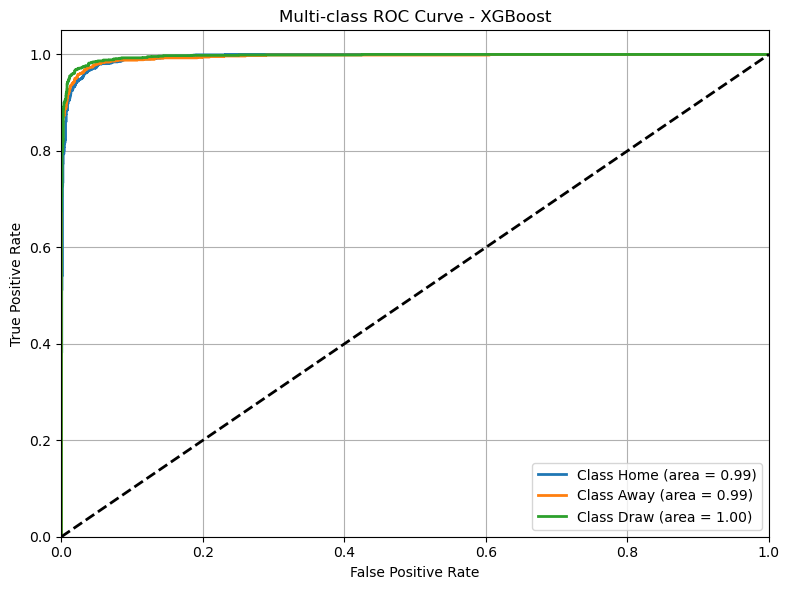

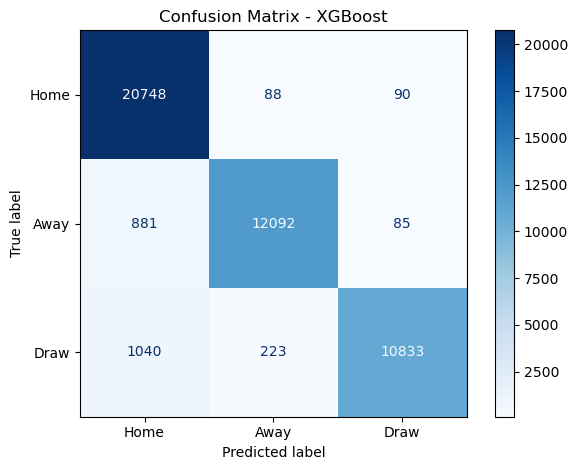


XGBoost Results:
Train Accuracy: 0.9501651716820988
Validation Accuracy: 0.9491644965277778
Validation Report:
               precision    recall  f1-score   support

        Home       0.92      0.99      0.95      8370
        Away       0.98      0.93      0.95      5224
        Draw       0.98      0.90      0.94      4838

    accuracy                           0.95     18432
   macro avg       0.96      0.94      0.95     18432
weighted avg       0.95      0.95      0.95     18432

Validation ROC-AUC (OvR): 0.9957569147444073
Test Accuracy: 0.9477647569444444
Test Report:
               precision    recall  f1-score   support

        Home       0.92      0.99      0.95     20926
        Away       0.97      0.93      0.95     13058
        Draw       0.98      0.90      0.94     12096

    accuracy                           0.95     46080
   macro avg       0.96      0.94      0.95     46080
weighted avg       0.95      0.95      0.95     46080

Test ROC-AUC (OvR): 0.9953283854

C:\Users\shaun\AppData\Local\Temp\ipykernel_6796\4055785736.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importances_df, x='Importance', y='Feature', palette='viridis')


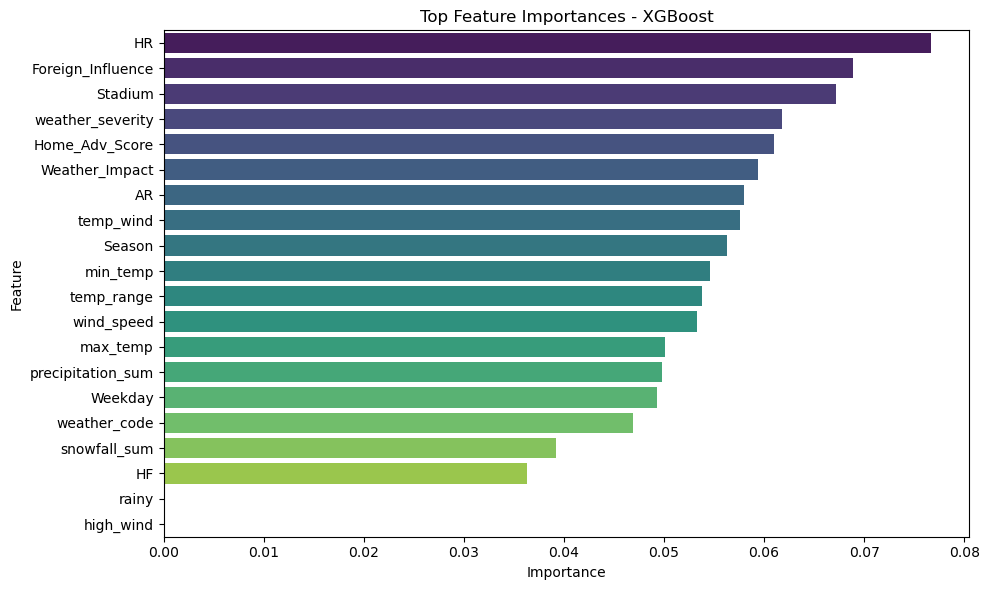

In [125]:
df_encoded = shuffle(df_encoded, random_state=42)
df_encoded['weather_severity'] = df_encoded['wind_speed'] * df_encoded['precipitation_sum']
df_encoded['high_wind'] = (df_encoded['wind_speed'] > 15).astype(int)
df_encoded['rainy'] = (df_encoded['precipitation_sum'] > 5).astype(int)
df_encoded['temp_wind'] = df_encoded['max_temp'] * df_encoded['wind_speed']
if 'max_temp' in df_encoded.columns and 'min_temp' in df_encoded.columns:
    df_encoded['temp_range'] = df_encoded['max_temp'] - df_encoded['min_temp']

leakage_columns = ['FTHG', 'FTAG', 'FTR_H', 'FTR_A', 'FTR_D','FTR_label', 'HTR', 'HTAG', 'HTHG','90s', 'rain_sum','Starts', 'Per_90_npxG+AG', 'Per_90_G+A-PK', 
            'apparent_temperature_min','Perf_G-PK','Per_90_G-PK','Exp_npxG','apparent_temperature_max', 'Per_90_npxG', 'Perf_PKatt','Pos', 'Avg Market Value in millions',
            'Market_Val_Ratio', 'HomeForm', 'AwayForm','Latitude', 'Longitude', 'Perf_PK', 'Perf_Gls', 'Per_90_Ast', 'Age', 'Perf_CrdR', 'Prog_PrgP','Prog_PrgR',
            'Squad', 'Exp_xG','Per_90_XG+AG', 'Per_90_XAG', 'Per_90_Gls', 'Per_90_G+A', 'Per_90_xG', 'Prog_PrgC', 'Perf_G+A', 'Perf_Ast', 'Min', 'Perf_CrdY', 'MP',
            'Exp_xAG', 'Exp_npxG+xAG','Day', 'Avg Age', 'Foreigners', 'Squad_size', 'ST_Diff', 'Home_Shot_Acc', 'Away_Shot_Acc','Total Market Value in millions',
            'AwayTeam' , 'AST', 'HS', 'HC', 'AC', 'AF', 'AS', 'HY', 'AY', 'Month', 'HomeTeam', 'HST', 'Year']

X = df_encoded.drop(columns=leakage_columns, errors='ignore')
y = df_encoded['FTR_label']
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64','float64','int32','float32']).columns.tolist()

Xy = pd.concat([X, y], axis=1)
Xy_dedup = Xy.drop_duplicates()
X = Xy_dedup.drop(columns=['FTR_label'])
y = Xy_dedup['FTR_label']
print("Original rows:", Xy.shape[0])
print("Deduplicated rows:", Xy_dedup.shape[0])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('scaler', StandardScaler())]), numerical_cols),
        ('cat', Pipeline(steps=[('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))]), categorical_cols)])

X = preprocessor.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split( X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

pipeline_lr = LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42)
pipeline_rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
pipeline_dt = DecisionTreeClassifier(max_depth=10,random_state=42)
pipeline_gb =  GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)
pipeline_xgb =  XGBClassifier(n_estimators=100, max_depth=5, random_state=42, use_label_encoder=False, eval_metric='mlogloss')

def evaluate_model(pipeline, X_train, y_train, X_val, y_val, X_test, y_test, name):
    pipeline.fit(X_train, y_train)
    y_train_pred = pipeline.predict(X_train)
    y_val_pred = pipeline.predict(X_val)
    y_test_pred = pipeline.predict(X_test)
    
    y_val_proba = pipeline.predict_proba(X_val)
    y_test_proba = pipeline.predict_proba(X_test)
    y_val_bin = label_binarize(y_val, classes=[0, 1, 2])
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
    
    val_roc = roc_auc_score(y_val_bin, y_val_proba, multi_class='ovr')
    test_roc = roc_auc_score(y_test_bin, y_test_proba, multi_class='ovr')

    plot_roc_multiclass(y_test, y_test_proba, classes=[0, 1, 2], model_name=f"{name}")
    plot_conf_matrix(y_test, y_test_pred, class_names=['Home', 'Away', 'Draw'], model_name=f"{name}")
    
    print(f"\n{name} Results:")
    print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
    print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
    print("Validation Report:\n", classification_report(y_val, y_val_pred, target_names=['Home', 'Away', 'Draw']))
    print("Validation ROC-AUC (OvR):", val_roc)
    print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
    print("Test Report:\n", classification_report(y_test, y_test_pred, target_names=['Home', 'Away', 'Draw']))
    print("Test ROC-AUC (OvR):", test_roc)
    
    if 'Tree' in name or 'Forest' in name or 'Boost' in name:
        importances = pipeline.feature_importances_
        feature_cols = numerical_cols + categorical_cols
        importances_df = pd.DataFrame({'Feature': feature_cols, 'Importance': importances})
        importances_df = importances_df.sort_values('Importance', ascending=False).head(20)  # Top 20 for clarity
    
        plt.figure(figsize=(10, 6))
        sns.barplot(data=importances_df, x='Importance', y='Feature', palette='viridis')
        plt.title(f"Top Feature Importances - {name}")
        plt.tight_layout()
        plt.savefig(f"feature_importance_{name}.png", dpi=300)
        plt.show()

# Evaluate
# evaluate_model(pipeline_lr, X_train, y_train, X_val, y_val, X_test, y_test, "Logistic Regression")
# evaluate_model(pipeline_rf, X_train, y_train, X_val, y_val, X_test, y_test, "Random Forest")
# evaluate_model(pipeline_dt, X_train, y_train, X_val, y_val, X_test, y_test, "Decision Tree")
# evaluate_model(pipeline_gb, X_train, y_train, X_val, y_val, X_test, y_test, "Gradient Boosting")
evaluate_model(pipeline_xgb, X_train, y_train, X_val, y_val, X_test, y_test, "XGBoost")